In [1]:
%matplotlib inline
#导入相关依赖库
import mindspore as ms
import mindspore.context as context
import numpy as np
import mindspore.dataset
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.nn.metrics import Accuracy
from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import  LossMonitor
context.set_context(mode=context.GRAPH_MODE, device_target='CPU') 
from mindspore.train.callback import ModelCheckpoint,CheckpointConfig
from mindspore import load_checkpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
DATA_DIR_TRAIN = "D:/DL/MNIST/MNIST/train" # 训练集信息
DATA_DIR_TEST = "D:/DL/MNIST/MNIST/test" # 测试集信息

In [3]:
def create_dataset(training=True, batch_size=128, resize=(28, 28),rescale=1/255, shift=-0.5, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    
    #定义改变形状、归一化和更改图片维度的操作。
    #改为（28,28）的形状
    resize_op = CV.Resize(resize)
    #rescale方法可以对数据集进行归一化和标准化操作，这里就是将像素值归一到0和1之间，shift参数可以让值域偏移至-0.5和0.5之间
    rescale_op = CV.Rescale(rescale, shift)
    #由高度、宽度、深度改为深度、高度、宽度
    hwc2chw_op = CV.HWC2CHW()
    
    # 利用map操作对原数据集进行调整
    ds = ds.map(input_columns="image", operations=[resize_op, rescale_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    #设定洗牌缓冲区的大小，从一定程度上控制打乱操作的混乱程度
    ds = ds.shuffle(buffer_size=buffer_size)
    #设定数据集的batch_size大小，并丢弃剩余的样本
    ds = ds.batch(batch_size, drop_remainder=True)
    
    return ds

In [4]:
#生成训练集
ds_train = create_dataset(True, batch_size=32)
#生成验证集，验证机不需要训练，所以不需要repeat
ds_eval = create_dataset(False, batch_size=32)

In [5]:
# 最简单的softmax分类器
class soft_max(nn.Cell):      
    def __init__(self):
        super(soft_max, self).__init__()
        self.flatten = nn.Flatten()
        self.Linear = nn.Dense(784,10)
    
    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.Linear(output)
        return output 

In [6]:
# 设置学习率，循环次数
lr = 0.001
num_epoch = 10
loss = nn.loss.SoftmaxCrossEntropyWithLogits( sparse=True, reduction='mean')
net = soft_max()
metrics={"Accuracy": Accuracy()}
#定义优化器为Adam优化器，并设定学习率
opt = nn.Adam(net.trainable_params(), lr)

In [7]:
model = Model(net, loss, opt, metrics)
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
# ckpt_cb = ModelCheckpoint(prefix='Soft_max', directory='D:/DL/MNIST/Mindspore/model',config=config_ck)

In [71]:
model.train(num_epoch, ds_train,callbacks=[LossMonitor(1875)],dataset_sink_mode=True)

[WARNING] ME(17272:12032,MainProcess):2022-03-23-09:24:41.791.796 [mindspore\train\model.py:550] The CPU cannot support dataset sink mode currently.So the training process will be performed with dataset not sink.


epoch: 1 step: 1875, loss is 0.37056875228881836
epoch: 2 step: 1875, loss is 0.2145053744316101
epoch: 3 step: 1875, loss is 0.46625757217407227
epoch: 4 step: 1875, loss is 0.26611530780792236
epoch: 5 step: 1875, loss is 0.07461484521627426
epoch: 6 step: 1875, loss is 0.11098938435316086
epoch: 7 step: 1875, loss is 0.1871420294046402
epoch: 8 step: 1875, loss is 0.5044193267822266
epoch: 9 step: 1875, loss is 0.33120453357696533
epoch: 10 step: 1875, loss is 0.30297377705574036


In [72]:
#使用测试集评估模型，打印总体准确率
metrics_result=model.eval(ds_eval)
print(metrics_result)

[WARNING] ME(17272:12032,MainProcess):2022-03-23-09:25:15.671.461 [mindspore\train\model.py:968] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


{'Accuracy': 0.9156650641025641}


In [8]:
net_test = soft_max()
load_checkpoint('D:/DL/MNIST/Mindspore/model/Soft_max-10_1875.ckpt',net = net_test)
Copymetrics = {
    'accuracy': nn.Accuracy(),
    'loss': nn.Loss(),
    'precision': nn.Precision(),
    'recall': nn.Recall(),
    'f1_score': nn.F1()
}
model_test = Model(net_test, loss,metrics=Copymetrics)
acc = model_test.eval(ds_eval)
acc

[WARNING] ME(18868:14372,MainProcess):2022-03-28-21:17:23.263.36 [mindspore\common\parameter.py:338] The parameter definition is deprecated.
Please set a unique name for the parameter 'Parameter (name=Parameter, shape=(10, 784), dtype=Float32, requires_grad=True)'.
[WARNING] ME(18868:14372,MainProcess):2022-03-28-21:17:23.273.34 [mindspore\common\parameter.py:338] The parameter definition is deprecated.
Please set a unique name for the parameter 'Parameter (name=Parameter, shape=(10,), dtype=Float32, requires_grad=True)'.
[WARNING] ME(18868:14372,MainProcess):2022-03-28-21:17:23.323.21 [mindspore\train\model.py:968] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


{'accuracy': 0.9200721153846154,
 'loss': 0.2897370919549408,
 'precision': array([0.93542074, 0.94013491, 0.93858751, 0.89059501, 0.90945274,
        0.88340807, 0.94642857, 0.93307087, 0.89312169, 0.92397043]),
 'recall': array([0.97750511, 0.98411297, 0.88856589, 0.92154916, 0.93170234,
        0.88340807, 0.94444444, 0.92307692, 0.86831276, 0.86805556]),
 'f1_score': array([0.956     , 0.96162139, 0.91289199, 0.90580771, 0.9204431 ,
        0.88340807, 0.94543547, 0.92804699, 0.88054251, 0.89514066])}

In [9]:
category_dict = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
cifar_ds = create_dataset(False, batch_size=1)
test_label = []
test_pred = []
for data in cifar_ds.create_dict_iterator(num_epochs=1, output_numpy=True):
    test_label.append(int(data['label']))
    input_img = ms.Tensor(data['image'])
    output = net_test(input_img)
    output = nn.Softmax(axis=1)(output)
    pred = output.asnumpy()
    pred = np.argmax(pred)
    test_pred.append(int(category_dict[pred]))

In [10]:
cm = confusion_matrix(test_label, test_pred)
cm

array([[ 958,    0,    0,    1,    0,   12,    3,    1,    3,    2],
       [   0, 1117,    2,    1,    0,    1,    4,    0,   10,    0],
       [  10,   11,  917,   17,   11,    7,   11,   10,   34,    4],
       [   2,    2,   17,  931,    1,   25,    3,    9,   14,    6],
       [   3,    6,    5,    2,  914,    3,    8,    2,   11,   28],
       [  10,    7,    4,   31,    7,  788,   16,    6,   19,    4],
       [  13,    4,    9,    1,    9,   11,  905,    2,    4,    0],
       [   3,   15,   15,   13,    8,    1,    0,  949,    4,   20],
       [  11,   16,    6,   28,   13,   35,    6,    5,  846,    8],
       [  14,   10,    2,   20,   42,    9,    0,   33,    3,  876]],
      dtype=int64)

<AxesSubplot:>

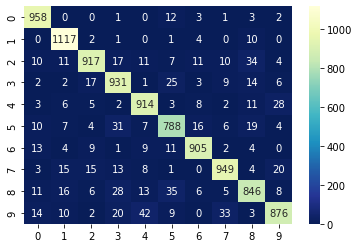

In [11]:
sns.heatmap(cm,cmap="YlGnBu_r",annot=True,fmt='d')